## Using Conv1D

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [2]:
# for synthetic time series

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# update with noise
series += noise(time, noise_level, seed=42)

In [4]:
SPLIT_TIME = 1000
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [12]:
WINDOW_SIZE = 30
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

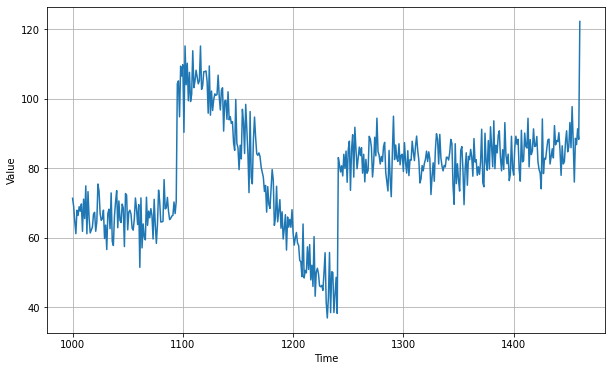

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [13]:
# turn array of data to dataset for training

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)                    # expand dimensions
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
# tf.keras.backend.clear_session()                    # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

In [14]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE)

In [15]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    #layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),         # no need to use, as input has already been expanded in prev line
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 200)                              # scale outputs by 200
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-traina

In [17]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [18]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [21]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [22]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [23]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [24]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
8/8 [==============================] - 17s 49ms/step - loss: 52.5617 - mae: 53.0610 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 38ms/step - loss: 51.5728 - mae: 52.0720 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 39ms/step - loss: 50.0434 - mae: 50.5428 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 1s 41ms/step - loss: 48.1874 - mae: 48.6868 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 41ms/step - loss: 46.0763 - mae: 46.5754 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 40ms/step - loss: 43.6692 - mae: 44.1683 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 39ms/step - loss: 40.9783 - mae: 41.4770 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 38ms/step - loss: 37.8791 - mae: 38.3774 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 39ms/step - loss: 34.3362 - mae: 34.8330 - lr: 2.

(1e-08, 0.0001, 0.0, 30.0)

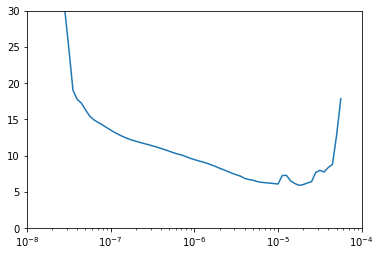

In [25]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [26]:
# making new model by fixing learning rate

model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 200)                              # scale outputs by 200
])

In [27]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [28]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [29]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [30]:
EPOCHS = 500
CALLBACKS = [early_stopping, model_checkpoint]

In [31]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/500
8/8 [==============================] - 8s 45ms/step - loss: 54.0815 - mae: 54.5804
Epoch 2/500
8/8 [==============================] - 1s 38ms/step - loss: 29.8908 - mae: 30.3887
Epoch 3/500
8/8 [==============================] - 1s 40ms/step - loss: 16.7394 - mae: 17.2334
Epoch 4/500
8/8 [==============================] - 1s 37ms/step - loss: 11.8635 - mae: 12.3556
Epoch 5/500
8/8 [==============================] - 1s 39ms/step - loss: 8.8213 - mae: 9.3096
Epoch 6/500
8/8 [==============================] - 1s 39ms/step - loss: 7.3432 - mae: 7.8269
Epoch 7/500
8/8 [==============================] - 1s 41ms/step - loss: 6.8143 - mae: 7.2965
Epoch 8/500
8/8 [==============================] - 1s 40ms/step - loss: 6.5231 - mae: 7.0045
Epoch 9/500
8/8 [==============================] - 1s 39ms/step - loss: 6.3642 - mae: 6.8451
Epoch 10/500
8/8 [==============================] - 1s 40ms/step - loss: 6.1806 - mae: 6.6606
Epoch 11/500
8/8 [==============================] - 1s 40ms/s

In [36]:
# for forecasting after training

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [37]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], WINDOW_SIZE)

In [38]:
rnn_forecast

array([[46.857166],
       [46.537323],
       [46.7515  ],
       ...,
       [84.79024 ],
       [84.001495],
       [84.18877 ]], dtype=float32)

In [40]:
len(rnn_forecast)

1432

In [42]:
WINDOW_SIZE

30

In [43]:
SPLIT_TIME

1000

In [41]:
rnn_forecast[970:-1, -1]

array([62.590607, 63.1645  , 63.575024, 63.596024, 64.01934 , 64.68661 ,
       64.96913 , 65.34684 , 64.93521 , 65.37274 , 65.13046 , 65.64995 ,
       65.974014, 66.26073 , 66.04989 , 66.097435, 66.02311 , 66.32775 ,
       66.09578 , 66.109024, 66.42476 , 66.56912 , 66.51307 , 66.49689 ,
       66.39272 , 66.36944 , 66.20724 , 66.25118 , 66.38572 , 66.62762 ,
       66.59677 , 66.32583 , 66.34629 , 66.11946 , 66.00128 , 66.042046,
       65.52889 , 65.30941 , 65.24115 , 64.97709 , 64.98548 , 65.0483  ,
       64.85307 , 64.82063 , 64.64556 , 65.30365 , 65.51998 , 65.965805,
       65.8027  , 65.971375, 66.36547 , 66.59185 , 65.48254 , 65.803696,
       65.833336, 65.77041 , 65.850525, 65.85125 , 66.16443 , 66.30702 ,
       66.398026, 66.147316, 66.04992 , 65.76108 , 66.12663 , 65.29882 ,
       64.991486, 64.917206, 64.36778 , 64.372375, 64.62442 , 64.19535 ,
       64.48647 , 64.71108 , 64.83012 , 64.556786, 65.35501 , 64.85207 ,
       64.39662 , 64.85077 , 64.92401 , 64.90657 , 

In [44]:
rnn_forecast = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1, -1]

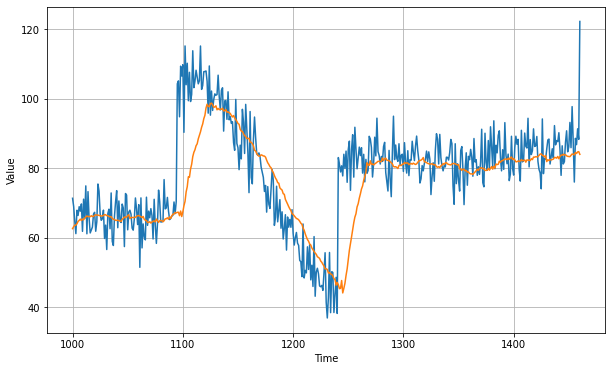

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.02848

<Figure size 432x288 with 0 Axes>

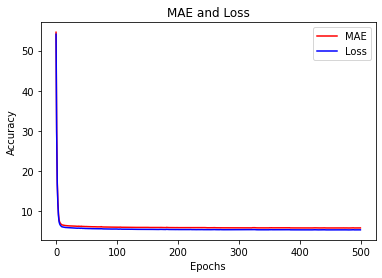

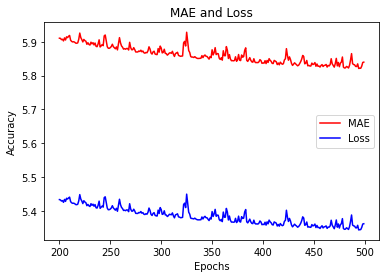

<Figure size 432x288 with 0 Axes>

In [47]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Sunspots Data - Dense

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [50]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2021-11-26 05:00:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-11-26 05:00:06 (80.0 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



In [51]:
import pandas as pd

df = pd.read_csv('/content/sunspots.csv', delimiter=',')
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [52]:
df.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9
3234,3234,2018-07-31,1.6


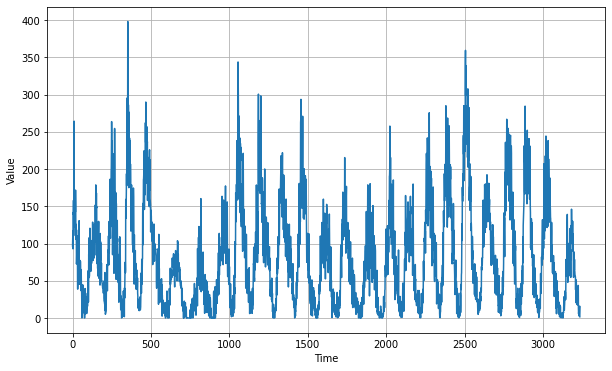

In [53]:
import csv
time_step = []
sunspots = []

with open('/content/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)                                    # throwing away 1st line which has column headers
    for row in reader:
        sunspots.append(float(row[2]))                # taking sunspots data from col 2
        time_step.append(int(row[0]))                 # taking time steps data from col 1

# convert to arrays

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# seasonality and noise present but no noticeable trend
# data is monthwise
# so seasonality is close around 11 yrs (or less than 125 months), see from the graph

In [54]:
series[:10]

array([ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2, 158. , 110.5, 126.5,
       125.8])

In [55]:
time[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [56]:
SPLIT_TIME = 3000
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [57]:
WINDOW_SIZE = 60                              # 60 months, each time slice is a month
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

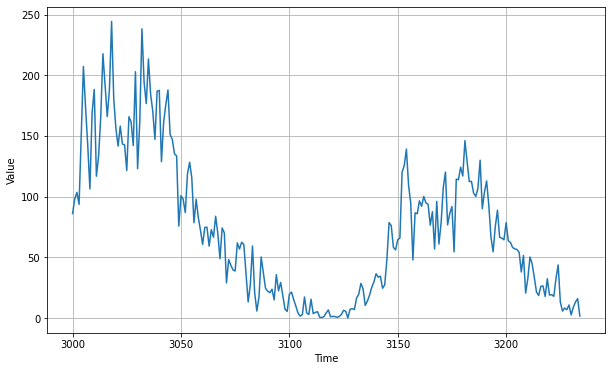

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [59]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [60]:
tf.random.set_seed(51)
np.random.seed(51)

In [61]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [62]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),                
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                1220      
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [64]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [65]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [67]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [68]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [69]:
EPOCHS = 120
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [70]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/120
92/92 [==============================] - 2s 10ms/step - loss: 57.2872 - mae: 57.7842 - lr: 1.0000e-08
Epoch 2/120
92/92 [==============================] - 1s 9ms/step - loss: 56.8865 - mae: 57.3838 - lr: 1.1220e-08
Epoch 3/120
92/92 [==============================] - 1s 9ms/step - loss: 56.4282 - mae: 56.9261 - lr: 1.2589e-08
Epoch 4/120
92/92 [==============================] - 1s 9ms/step - loss: 55.9037 - mae: 56.4016 - lr: 1.4125e-08
Epoch 5/120
92/92 [==============================] - 1s 9ms/step - loss: 55.3038 - mae: 55.8017 - lr: 1.5849e-08
Epoch 6/120
92/92 [==============================] - 1s 9ms/step - loss: 54.6195 - mae: 55.1173 - lr: 1.7783e-08
Epoch 7/120
92/92 [==============================] - 1s 9ms/step - loss: 53.8399 - mae: 54.3371 - lr: 1.9953e-08
Epoch 8/120
92/92 [==============================] - 1s 10ms/step - loss: 52.9522 - mae: 53.4500 - lr: 2.2387e-08
Epoch 9/120
92/92 [==============================] - 1s 9ms/step - loss: 51.9417 - mae: 52.438

(1e-08, 0.001, 10.0, 50.0)

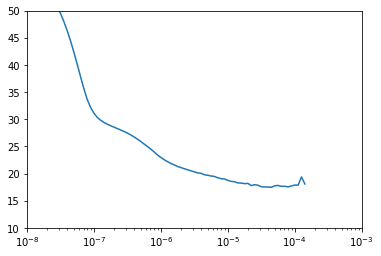

In [71]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 10, 50])

In [72]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),                
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [73]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [74]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [75]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [76]:
EPOCHS = 400
CALLBACKS = [early_stopping, model_checkpoint]

In [77]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/400
92/92 [==============================] - 2s 10ms/step - loss: 27.7373 - mae: 28.2315
Epoch 2/400
92/92 [==============================] - 1s 9ms/step - loss: 20.0178 - mae: 20.5108
Epoch 3/400
92/92 [==============================] - 1s 9ms/step - loss: 18.9031 - mae: 19.3964
Epoch 4/400
92/92 [==============================] - 1s 9ms/step - loss: 18.2329 - mae: 18.7245
Epoch 5/400
92/92 [==============================] - 1s 9ms/step - loss: 18.2480 - mae: 18.7416
Epoch 6/400
92/92 [==============================] - 1s 9ms/step - loss: 18.2176 - mae: 18.7096
Epoch 7/400
92/92 [==============================] - 1s 9ms/step - loss: 17.9885 - mae: 18.4811
Epoch 8/400
92/92 [==============================] - 1s 9ms/step - loss: 17.6364 - mae: 18.1291
Epoch 9/400
92/92 [==============================] - 1s 9ms/step - loss: 17.5024 - mae: 17.9952
Epoch 10/400
92/92 [==============================] - 1s 9ms/step - loss: 17.9474 - mae: 18.4391
Epoch 11/400
92/92 [==================

<function matplotlib.pyplot.show>

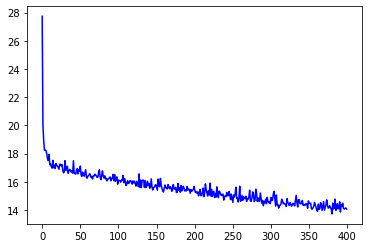

In [78]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show

<Figure size 432x288 with 0 Axes>

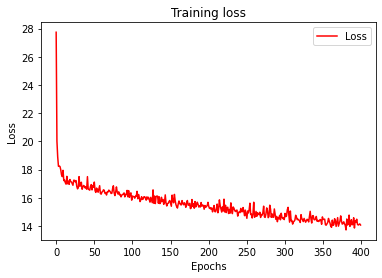

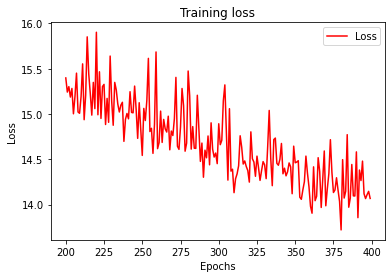

<Figure size 432x288 with 0 Axes>

In [79]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,400)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

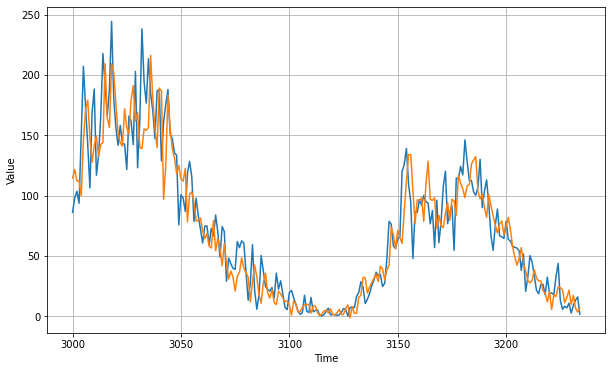

In [80]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [81]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

16.367146

## Sunspots Data - CNN + LSTM + Dense

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [83]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [84]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2021-11-26 05:23:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-11-26 05:23:22 (87.1 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



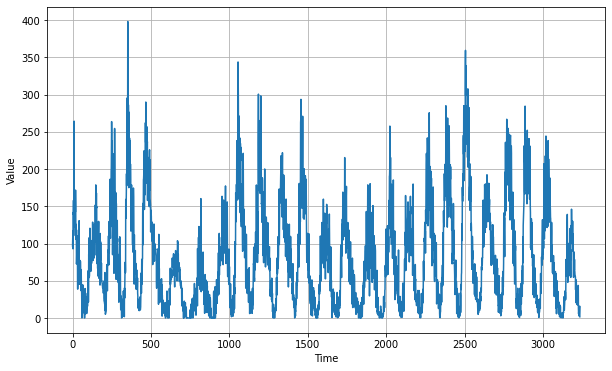

In [85]:
import csv
time_step = []
sunspots = []

with open('/content/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [86]:
SPLIT_TIME = 3000
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [91]:
WINDOW_SIZE = 30                              # 30 months, each time slice is a month
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

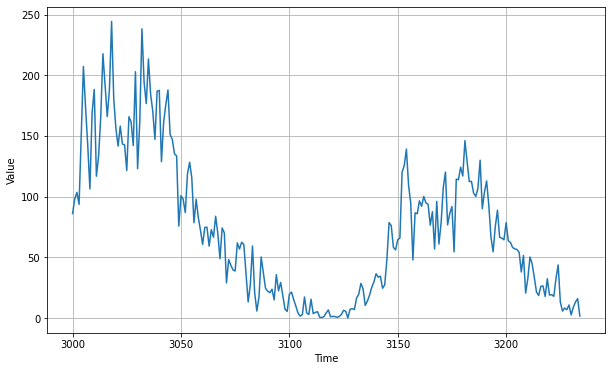

In [88]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [89]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [90]:
tf.random.set_seed(51)
np.random.seed(51)

In [92]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [93]:
dataset

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [94]:
x_train.shape

(3000,)

In [95]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [96]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 30)                1950      
                                                                 
 dense_9 (Dense)             (None, 10)                310       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
 lambda_2 (Lambda)           (None, 1)                

In [97]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [98]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [99]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [100]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [101]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [102]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
47/47 [==============================] - 5s 24ms/step - loss: 57.6283 - mae: 58.1252 - lr: 1.0000e-07
Epoch 2/100
47/47 [==============================] - 1s 24ms/step - loss: 41.9827 - mae: 42.4799 - lr: 1.1220e-07
Epoch 3/100
47/47 [==============================] - 1s 25ms/step - loss: 37.3267 - mae: 37.8235 - lr: 1.2589e-07
Epoch 4/100
47/47 [==============================] - 1s 24ms/step - loss: 34.9898 - mae: 35.4862 - lr: 1.4125e-07
Epoch 5/100
47/47 [==============================] - 1s 24ms/step - loss: 33.4818 - mae: 33.9776 - lr: 1.5849e-07
Epoch 6/100
47/47 [==============================] - 1s 23ms/step - loss: 32.2921 - mae: 32.7877 - lr: 1.7783e-07
Epoch 7/100
47/47 [==============================] - 1s 24ms/step - loss: 31.3348 - mae: 31.8305 - lr: 1.9953e-07
Epoch 8/100
47/47 [==============================] - 1s 24ms/step - loss: 30.5445 - mae: 31.0403 - lr: 2.2387e-07
Epoch 9/100
47/47 [==============================] - 1s 24ms/step - loss: 29.8994 - mae:

(1e-07, 0.001, 15.0, 50.0)

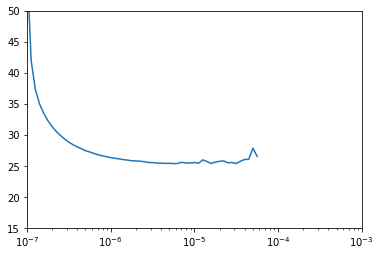

In [103]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-3, 15, 50])

In [104]:
history.history

{'loss': [57.628292083740234,
  41.9826774597168,
  37.326683044433594,
  34.98984146118164,
  33.481788635253906,
  32.292057037353516,
  31.334808349609375,
  30.544466018676758,
  29.89939308166504,
  29.31252670288086,
  28.831422805786133,
  28.403867721557617,
  28.060808181762695,
  27.75543785095215,
  27.4387149810791,
  27.238269805908203,
  27.001684188842773,
  26.78849983215332,
  26.623153686523438,
  26.477685928344727,
  26.326494216918945,
  26.223798751831055,
  26.120582580566406,
  26.01048469543457,
  25.938047409057617,
  25.819305419921875,
  25.802871704101562,
  25.750938415527344,
  25.6705265045166,
  25.55086898803711,
  25.528900146484375,
  25.446853637695312,
  25.43723487854004,
  25.395435333251953,
  25.42557144165039,
  25.368061065673828,
  25.38787841796875,
  25.580080032348633,
  25.453338623046875,
  25.471454620361328,
  25.541784286499023,
  25.416927337646484,
  25.969118118286133,
  25.705055236816406,
  25.383089065551758,
  25.6076354980468

In [105]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [106]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [107]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [108]:
early_stopping    = EarlyStopping(monitor='loss', patience=60)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [109]:
EPOCHS = 400
CALLBACKS = [early_stopping, model_checkpoint]

In [110]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/400
47/47 [==============================] - 5s 23ms/step - loss: 31.7301 - mae: 32.2262
Epoch 2/400
47/47 [==============================] - 1s 24ms/step - loss: 27.3328 - mae: 27.8278
Epoch 3/400
47/47 [==============================] - 1s 23ms/step - loss: 26.1850 - mae: 26.6796
Epoch 4/400
47/47 [==============================] - 1s 24ms/step - loss: 25.7090 - mae: 26.2034
Epoch 5/400
47/47 [==============================] - 1s 23ms/step - loss: 25.5235 - mae: 26.0180
Epoch 6/400
47/47 [==============================] - 1s 23ms/step - loss: 25.4228 - mae: 25.9172
Epoch 7/400
47/47 [==============================] - 1s 23ms/step - loss: 25.4271 - mae: 25.9214
Epoch 8/400
47/47 [==============================] - 1s 24ms/step - loss: 25.2875 - mae: 25.7817
Epoch 9/400
47/47 [==============================] - 1s 23ms/step - loss: 25.3832 - mae: 25.8769
Epoch 10/400
47/47 [==============================] - 1s 23ms/step - loss: 25.3131 - mae: 25.8070
Epoch 11/400
47/47 [=========

<Figure size 432x288 with 0 Axes>

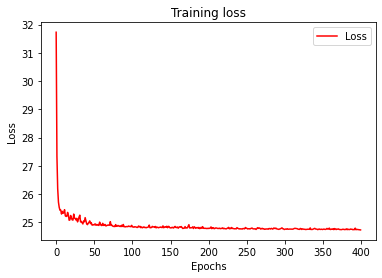

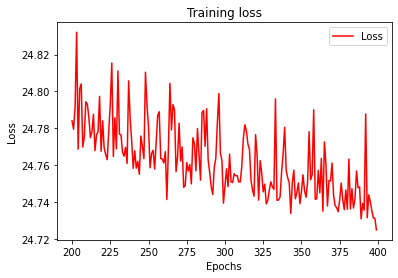

<Figure size 432x288 with 0 Axes>

In [111]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,400)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [112]:
best_model = tf.keras.models.load_model('best_model.h5')

In [113]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = best_model.predict(ds)
    return forecast

In [114]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1, -1]

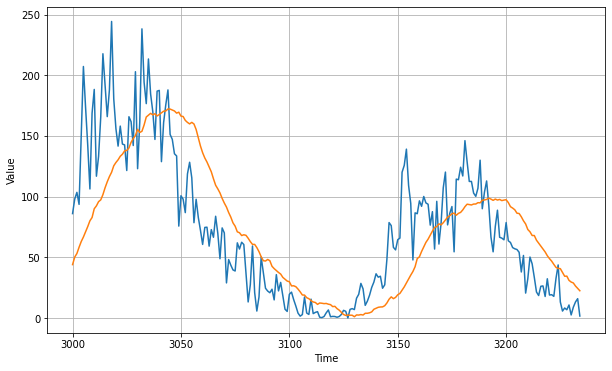

In [115]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [116]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

31.186876

In [117]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [118]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 64)          16896     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_14 (Dense)            (None, 30)                1950      
                                                                 
 dense_15 (Dense)            (None, 10)                310       
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                                 
 lambda_4 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 52,191
Trainable params: 52,191
Non-trai

In [119]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [120]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [121]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [122]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [123]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [124]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
47/47 [==============================] - 5s 22ms/step - loss: 178.8649 - mae: 179.3649 - lr: 1.0000e-07
Epoch 2/100
47/47 [==============================] - 1s 23ms/step - loss: 122.0901 - mae: 122.5901 - lr: 1.1220e-07
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 74.8269 - mae: 75.3256 - lr: 1.2589e-07
Epoch 4/100
47/47 [==============================] - 1s 23ms/step - loss: 57.2490 - mae: 57.7458 - lr: 1.4125e-07
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 51.9172 - mae: 52.4136 - lr: 1.5849e-07
Epoch 6/100
47/47 [==============================] - 1s 23ms/step - loss: 48.6563 - mae: 49.1527 - lr: 1.7783e-07
Epoch 7/100
47/47 [==============================] - 1s 24ms/step - loss: 45.9602 - mae: 46.4567 - lr: 1.9953e-07
Epoch 8/100
47/47 [==============================] - 1s 24ms/step - loss: 43.4783 - mae: 43.9745 - lr: 2.2387e-07
Epoch 9/100
47/47 [==============================] - 1s 23ms/step - loss: 41.2118 - 

(1e-07, 0.001, 15.0, 50.0)

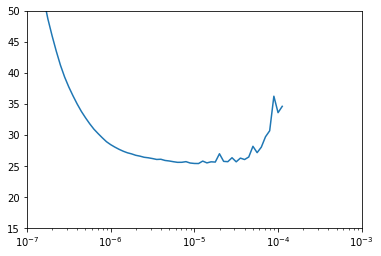

In [125]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-3, 15, 50])

## Exercise 16 - CNN + LSTM + Dense

For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [127]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [128]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /content/daily-min-temperatures.csv

--2021-11-26 05:52:24--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/content/daily-min-temperatures.csv’

/content/daily-min- 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-11-26 05:52:24 (5.61 MB/s) - ‘/content/daily-min-temperatures.csv’ saved [67921/67921]



In [129]:
import pandas as pd

df = pd.read_csv('/content/daily-min-temperatures.csv', delimiter=',')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [130]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [131]:
df.shape

(3650, 2)

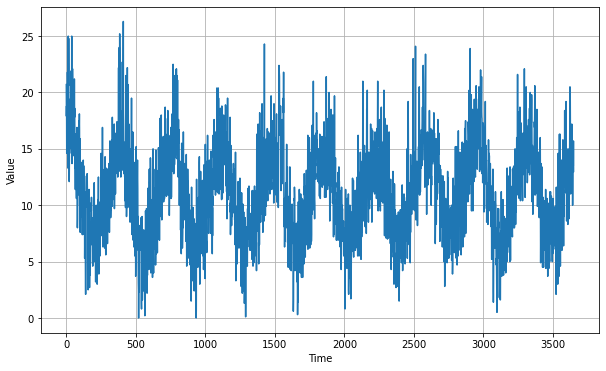

In [132]:
import csv
time_step = []
temps = []

with open('/content/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [133]:
time_step[:5]

[0, 1, 2, 3, 4]

In [134]:
temps[:5]

[20.7, 17.9, 18.8, 14.6, 15.8]

In [135]:
SPLIT_TIME = 2500                                             # 2500 training records
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [136]:
WINDOW_SIZE = 30
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

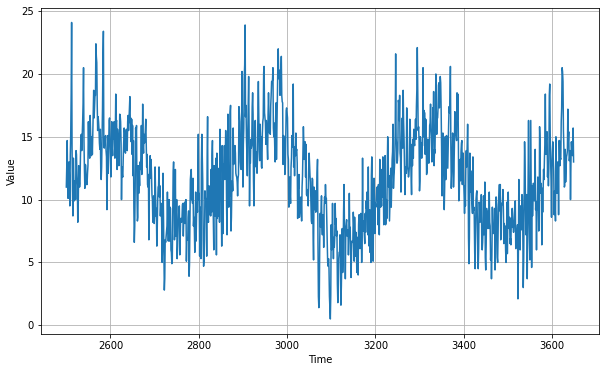

In [137]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [138]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [139]:
tf.random.set_seed(51)
np.random.seed(51)

In [140]:
WINDOW_SIZE = 64
BATCH_SIZE = 256

In [141]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [142]:
x_train.shape

(2500,)

In [143]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [144]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          24832     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 30)                1950      
                                                                 
 dense_18 (Dense)            (None, 10)                310       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
 lambda_5 (Lambda)           (None, 1)                

In [145]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [146]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [147]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [148]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [149]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [150]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
10/10 [==============================] - 5s 57ms/step - loss: 36.6266 - mae: 37.1264 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 64ms/step - loss: 35.8751 - mae: 36.3749 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 63ms/step - loss: 34.6989 - mae: 35.1987 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 63ms/step - loss: 33.1894 - mae: 33.6890 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 63ms/step - loss: 31.2024 - mae: 31.7018 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 64ms/step - loss: 28.5438 - mae: 29.0430 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 62ms/step - loss: 24.9859 - mae: 25.4846 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 64ms/step - loss: 20.5488 - mae: 21.0466 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 1s 65ms/step - loss: 15.5619 - mae:

(1e-08, 0.001, 0.0, 60.0)

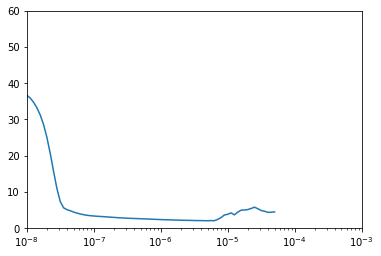

In [151]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 60])

In [152]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [153]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [154]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [155]:
early_stopping    = EarlyStopping(monitor='loss', patience=60)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [156]:
EPOCHS = 200
CALLBACKS = [early_stopping, model_checkpoint]

In [157]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/200
10/10 [==============================] - 5s 50ms/step - loss: 18.8696 - mae: 19.3542
Epoch 2/200
10/10 [==============================] - 1s 60ms/step - loss: 2.7408 - mae: 3.2079
Epoch 3/200
10/10 [==============================] - 1s 63ms/step - loss: 2.4373 - mae: 2.8991
Epoch 4/200
10/10 [==============================] - 1s 62ms/step - loss: 2.1814 - mae: 2.6387
Epoch 5/200
10/10 [==============================] - 1s 63ms/step - loss: 2.0877 - mae: 2.5436
Epoch 6/200
10/10 [==============================] - 1s 65ms/step - loss: 2.0472 - mae: 2.5022
Epoch 7/200
10/10 [==============================] - 1s 65ms/step - loss: 2.0271 - mae: 2.4819
Epoch 8/200
10/10 [==============================] - 1s 65ms/step - loss: 2.0151 - mae: 2.4698
Epoch 9/200
10/10 [==============================] - 1s 60ms/step - loss: 2.0160 - mae: 2.4710
Epoch 10/200
10/10 [==============================] - 1s 58ms/step - loss: 2.0173 - mae: 2.4725
Epoch 11/200
10/10 [===========================

In [158]:
best_model = tf.keras.models.load_model('best_model.h5')

In [159]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = best_model.predict(ds)
    return forecast

In [160]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1, -1]

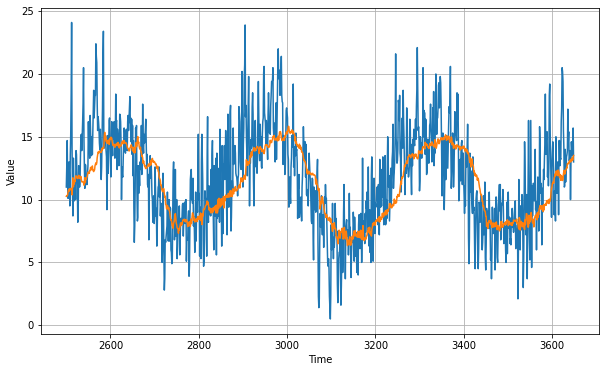

In [161]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [162]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.344924

## Exercise 16 - Dense

In [163]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [164]:
tf.random.set_seed(51)
np.random.seed(51)

In [165]:
WINDOW_SIZE = 64
BATCH_SIZE = 256

In [166]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [168]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),                
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [169]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 30)                1950      
                                                                 
 dense_24 (Dense)            (None, 10)                310       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,271
Trainable params: 2,271
Non-trainable params: 0
_________________________________________________________________


In [170]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [171]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [172]:
early_stopping    = EarlyStopping(monitor='loss', patience=25)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [173]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [174]:
EPOCHS = 200
CALLBACKS = [early_stopping, model_checkpoint, lr_schedule]

In [175]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/200
10/10 [==============================] - 1s 47ms/step - loss: 6.6898 - mae: 7.1836 - lr: 1.0000e-08
Epoch 2/200
10/10 [==============================] - 1s 46ms/step - loss: 6.6859 - mae: 7.1797 - lr: 1.1220e-08
Epoch 3/200
10/10 [==============================] - 1s 42ms/step - loss: 6.6799 - mae: 7.1738 - lr: 1.2589e-08
Epoch 4/200
10/10 [==============================] - 1s 44ms/step - loss: 6.6727 - mae: 7.1665 - lr: 1.4125e-08
Epoch 5/200
10/10 [==============================] - 1s 43ms/step - loss: 6.6645 - mae: 7.1582 - lr: 1.5849e-08
Epoch 6/200
10/10 [==============================] - 1s 43ms/step - loss: 6.6551 - mae: 7.1489 - lr: 1.7783e-08
Epoch 7/200
10/10 [==============================] - 1s 46ms/step - loss: 6.6446 - mae: 7.1383 - lr: 1.9953e-08
Epoch 8/200
10/10 [==============================] - 1s 44ms/step - loss: 6.6328 - mae: 7.1265 - lr: 2.2387e-08
Epoch 9/200
10/10 [==============================] - 1s 43ms/step - loss: 6.6196 - mae: 7.1133 - lr: 2.5

(1e-09, 0.1, 0.0, 15.0)

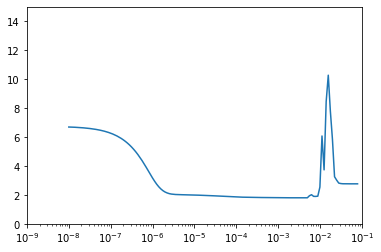

In [180]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-9, 1e-1, 0, 15])

In [177]:
history.history

{'loss': [6.6897687911987305,
  6.68588924407959,
  6.6799445152282715,
  6.672735214233398,
  6.664464473724365,
  6.655121326446533,
  6.644632816314697,
  6.632838249206543,
  6.61963415145874,
  6.604908466339111,
  6.588298320770264,
  6.5698442459106445,
  6.549075126647949,
  6.5257062911987305,
  6.499686241149902,
  6.470530986785889,
  6.437900066375732,
  6.40148401260376,
  6.3607354164123535,
  6.315123081207275,
  6.26434850692749,
  6.207508563995361,
  6.144135475158691,
  6.0735602378845215,
  5.994969367980957,
  5.907822608947754,
  5.810821533203125,
  5.703257083892822,
  5.584872245788574,
  5.454551696777344,
  5.3106513023376465,
  5.152218818664551,
  4.980587005615234,
  4.7934651374816895,
  4.591596603393555,
  4.376707553863525,
  4.147744178771973,
  3.9090113639831543,
  3.6647212505340576,
  3.4174294471740723,
  3.178025484085083,
  2.952709436416626,
  2.7455525398254395,
  2.567194938659668,
  2.4180431365966797,
  2.2981882095336914,
  2.207405328750

In [181]:
model = Sequential([
    layers.InputLayer(input_shape=[WINDOW_SIZE]),                
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [182]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [183]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [184]:
early_stopping    = EarlyStopping(monitor='loss', patience=60)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [185]:
EPOCHS = 100
CALLBACKS = [early_stopping, model_checkpoint]

In [186]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/100
10/10 [==============================] - 1s 50ms/step - loss: 5.3525 - mae: 5.8357
Epoch 2/100
10/10 [==============================] - 1s 44ms/step - loss: 2.3845 - mae: 2.8476
Epoch 3/100
10/10 [==============================] - 1s 47ms/step - loss: 2.0553 - mae: 2.5125
Epoch 4/100
10/10 [==============================] - 1s 45ms/step - loss: 1.9027 - mae: 2.3569
Epoch 5/100
10/10 [==============================] - 1s 46ms/step - loss: 1.8614 - mae: 2.3150
Epoch 6/100
10/10 [==============================] - 1s 47ms/step - loss: 1.8472 - mae: 2.3005
Epoch 7/100
10/10 [==============================] - 1s 43ms/step - loss: 1.8382 - mae: 2.2909
Epoch 8/100
10/10 [==============================] - 1s 45ms/step - loss: 1.8338 - mae: 2.2863
Epoch 9/100
10/10 [==============================] - 1s 45ms/step - loss: 1.8307 - mae: 2.2832
Epoch 10/100
10/10 [==============================] - 1s 45ms/step - loss: 1.8270 - mae: 2.2794
Epoch 11/100
10/10 [=============================

In [187]:
best_model = tf.keras.models.load_model('best_model.h5')

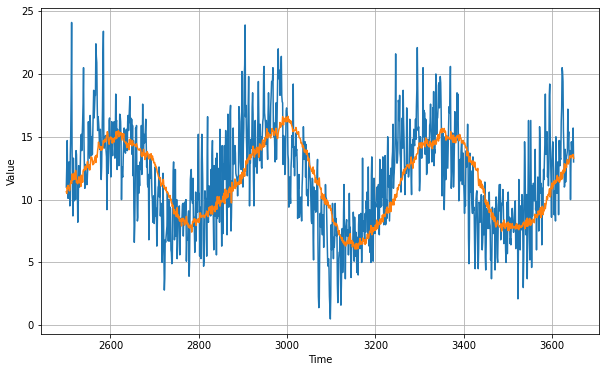

In [188]:
forecast=[]

for time in range(len(series) - WINDOW_SIZE):
    forecast.append(best_model.predict(series[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[SPLIT_TIME - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [189]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.3719473